In [ ]:
!pip install hmmlearn
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
!pip install ffn
import ffn
from matplotlib import cm
import numpy as np
%matplotlib inline
from sklearn.preprocessing import scale # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, r2_score
import sklearn.mixture as mix
import math, pickle
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings
import seaborn as sns
sns.set()
from hmmlearn.hmm import GaussianHMM
from random import randint
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
warnings.filterwarnings("ignore")

In [3]:
import pandas_datareader as web
df = web.DataReader('^IXIC', data_source = 'yahoo', start = '2000-01-01')

print(f'Nasdaq Composite Index:')
print(df.head())
print('\n')
print(df.shape)

Nasdaq Composite Index:
                   High          Low         Open        Close      Volume    Adj Close
Date                                                                                   
2000-01-03  4192.189941  3989.709961  4186.189941  4131.149902  1510070000  4131.149902
2000-01-04  4073.250000  3898.229980  4020.000000  3901.689941  1511840000  3901.689941
2000-01-05  3924.209961  3734.870117  3854.350098  3877.540039  1735670000  3877.540039
2000-01-06  3868.760010  3715.620117  3834.439941  3727.129883  1598320000  3727.129883
2000-01-07  3882.669922  3711.090088  3711.090088  3882.620117  1634930000  3882.620117


(5331, 6)


In [4]:
data = df[['High','Low','Open','Adj Close', 'Volume']]
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)
data.tail()

,High,Low,Open,Adj Close,Volume,returns
Date,,,,,,
2021-03-05,12941.209961,12397.049805,12860.040039,12920.150391,7696900000,0.015340
2021-03-08,13001.000000,12599.230469,12904.259766,12609.160156,5971260000,-0.024365
2021-03-09,13151.540039,12882.490234,12923.070312,13073.820312,6294910000,0.036188
2021-03-10,13277.110352,13035.440430,13234.730469,13068.830078,5991730000,-0.000382
2021-03-11,13433.619141,13246.325195,13273.299805,13398.672852,1165590280,0.024926


count     5330.000000
mean      3876.284459
std       2523.035916
min       1114.109985
25%       2110.867493
50%       2743.835083
75%       4952.244995
max      14095.469727
Name: Adj Close, dtype: float64

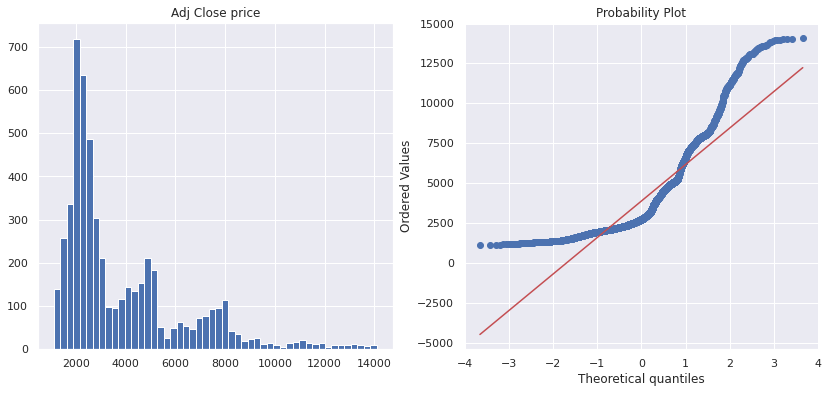

In [5]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Adj Close'].hist(bins=50)
plt.title('Adj Close price')
plt.subplot(1,2,2)
stats.probplot(data['Adj Close'], plot=plt);
data['Adj Close'].describe().T

In [6]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['returns'].dropna())

(-16.819660693633463,
 1.1810667656873766e-29,
 17,
 5312,
 {'1%': -3.43158163833398,
  '10%': -2.567059707982438,
  '5%': -2.8620842579974095},
 -28895.478649254197)

In [7]:
data['state'] = data['returns'].apply(lambda x: 'up' if (x > 0.001)\
else ('down' if (x < -0.001)\
else 'no_change'))
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state
Date,,,,,,,
2021-03-05,12941.209961,12397.049805,12860.040039,12920.150391,7696900000,0.015340,up
2021-03-08,13001.000000,12599.230469,12904.259766,12609.160156,5971260000,-0.024365,down
2021-03-09,13151.540039,12882.490234,12923.070312,13073.820312,6294910000,0.036188,up
2021-03-10,13277.110352,13035.440430,13234.730469,13068.830078,5991730000,-0.000382,no_change
2021-03-11,13433.619141,13246.325195,13273.299805,13398.672852,1165590280,0.024926,up


In [8]:
data['prev_state'] = data['state'].shift(1)
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state,prev_state
Date,,,,,,,,
2021-03-05,12941.209961,12397.049805,12860.040039,12920.150391,7696900000,0.015340,up,down
2021-03-08,13001.000000,12599.230469,12904.259766,12609.160156,5971260000,-0.024365,down,up
2021-03-09,13151.540039,12882.490234,12923.070312,13073.820312,6294910000,0.036188,up,down
2021-03-10,13277.110352,13035.440430,13234.730469,13068.830078,5991730000,-0.000382,no_change,up
2021-03-11,13433.619141,13246.325195,13273.299805,13398.672852,1165590280,0.024926,up,no_change


In [9]:
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
state_space_matrix

state,down,no_change,up
prev_state,,,
down,924,153,1131
no_change,184,43,239
up,1099,270,1286


In [10]:
print(state_space_matrix.sum())

state
down         2207
no_change     466
up           2656
dtype: int64


In [11]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()), axis=1)
transition_matrix

state,down,no_change,up
prev_state,,,
down,0.418478,0.069293,0.512228
no_change,0.394850,0.092275,0.512876
up,0.413936,0.101695,0.484369


In [12]:
print(transition_matrix.sum(axis=1))

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [13]:
t0 = transition_matrix.copy()
t1 = round(t0.dot(t0), 4)
t1

state,down,no_change,up
prev_state,,,
down,0.4145,0.0875,0.4980
no_change,0.4140,0.0880,0.4980
up,0.4139,0.0873,0.4988


In [14]:
t2 = round(t0.dot(t1), 4)
t2

state,down,no_change,up
prev_state,,,
down,0.4142,0.0874,0.4984
no_change,0.4141,0.0874,0.4984
up,0.4142,0.0875,0.4984


In [15]:
t3 = round(t0.dot(t2), 4)
t3

state,down,no_change,up
prev_state,,,
down,0.4142,0.0875,0.4984
no_change,0.4142,0.0875,0.4984
up,0.4142,0.0874,0.4984


In [16]:
pd.DataFrame(np.linalg.matrix_power(t0,4))

<IPython.core.display.Javascript object>

,0,1,2
0,0.414148,0.087452,0.4984
1,0.414148,0.087452,0.4984
2,0.414148,0.087452,0.4984


In [17]:
# find the equilibrium matrix
i=1
a= t0.copy()
b = t0.dot(t0)
while(not(a.equals(b))):
  print('iteration number:' +str(i))
  i += 1
  a = b.copy()
  b = b.dot(t0)

iteration number:1
iteration number:2
iteration number:3
iteration number:4
iteration number:5
iteration number:6
iteration number:7
iteration number:8
iteration number:9
iteration number:10
iteration number:11


In [18]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(transition_matrix)
pprint(edges_wts)

{('down', 'down'): 0.41847826086956524,
 ('down', 'no_change'): 0.06929347826086957,
 ('down', 'up'): 0.5122282608695652,
 ('no_change', 'down'): 0.3948497854077253,
 ('no_change', 'no_change'): 0.09227467811158799,
 ('no_change', 'up'): 0.5128755364806867,
 ('up', 'down'): 0.41393596986817327,
 ('up', 'no_change'): 0.1016949152542373,
 ('up', 'up'): 0.48436911487758944}


Nodes:
['down', 'no_change', 'up']

Edges:


<IPython.core.display.Javascript object>

           0          1                                                  2
0       down       down  {'weight': 0.41847826086956524, 'label': 0.418...
1       down  no_change  {'weight': 0.06929347826086957, 'label': 0.069...
2       down         up  {'weight': 0.5122282608695652, 'label': 0.5122...
3  no_change       down  {'weight': 0.3948497854077253, 'label': 0.3948...
4  no_change  no_change  {'weight': 0.09227467811158799, 'label': 0.092...
5  no_change         up  {'weight': 0.5128755364806867, 'label': 0.5128...
6         up       down  {'weight': 0.41393596986817327, 'label': 0.413...
7         up  no_change  {'weight': 0.1016949152542373, 'label': 0.1016...
8         up         up  {'weight': 0.48436911487758944, 'label': 0.484...
None


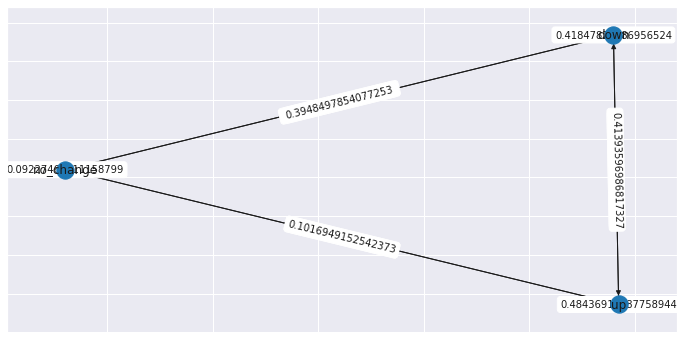

In [19]:
import networkx as nx

states = ['up', 'down', 'no_change']

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(pd.DataFrame(G.edges(data=True)))    

plt.figure(figsize=(12,6))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
print(nx.draw_networkx(G, pos))

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood                7983.335
Date:                Fri, 12 Mar 2021   AIC                         -15942.669
Time:                        09:01:28   BIC                         -15872.781
Sample:                             0   HQIC                        -15917.296
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      7.908      0.000       0.001       0.002
sigma2      2.777e-05   3.87e-06      7.171      0.0

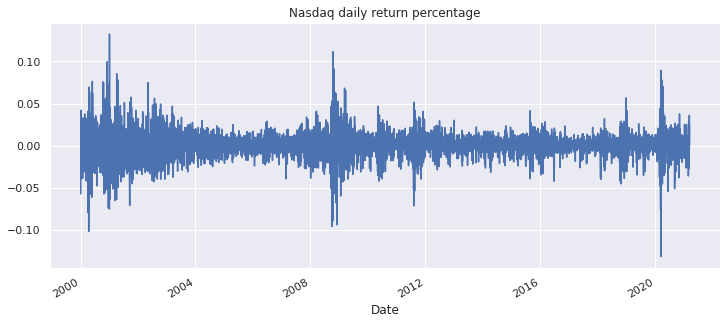

In [20]:
import statsmodels.api as sm

# Plot the data
data['returns'].plot(title='Nasdaq daily return percentage', figsize=(12,5))

data.dropna(inplace=True)

model = sm.tsa.MarkovRegression(data['returns'][-2500:], k_regimes=3,
                                switching_variance=True)


# launch the modelling process on the dataset
np.random.seed(123)
res_1 = model.fit(search_reps=50)

"""We specify that 50 random perturbations from the starting parameter 
vector are examined and the best one used as the actual starting parameters. 

Because of the random nature of the search, the random seed generator 
beforehand allow replication of the result"""

print(res_1.summary())

In [21]:
pred_1 = res_1.predict()
pred_1 = pd.DataFrame(pred_1).tail(20)
pred_1.rename(columns ={0: 'Predicted'}, inplace=True)
com_1 = pd.concat([pred_1, data['returns'].tail(20)], axis=1)
com_1 = com_1.reset_index()
com_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2021-02-11,0.001374,0.003803
1,2021-02-12,0.001272,0.004957
2,2021-02-16,0.001043,-0.003409
3,2021-02-17,0.000716,-0.005855
4,2021-02-18,0.000380,-0.007196
5,2021-02-19,0.000010,0.000656
6,2021-02-22,-0.000808,-0.024915
7,2021-02-23,-0.000980,-0.005026
8,2021-02-24,-0.001348,0.009812
9,2021-02-25,-0.001983,-0.035826


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['returns'],
                         name="Actual returns"))

fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted returns",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

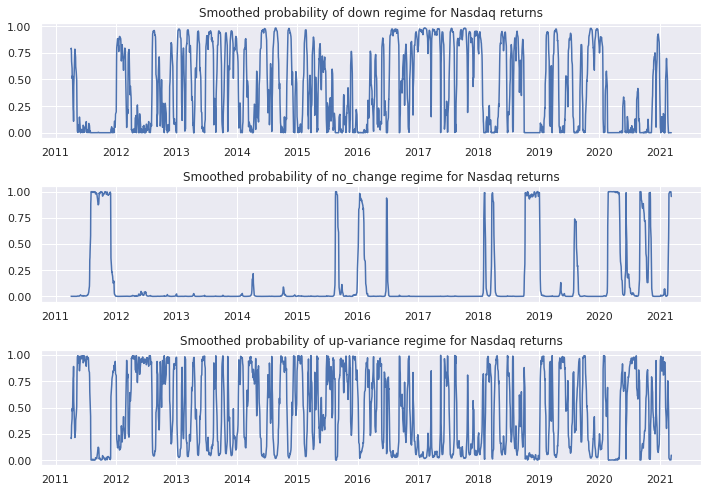

In [23]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_1.smoothed_marginal_probabilities[0])
#ax.fill_between(data['returns'].index, 0,  where=data['returns'].values, color='gray', alpha=0.3)
ax.set(title='Smoothed probability of down regime for Nasdaq returns')
ax = axes[1]
ax.plot(res_1.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime for Nasdaq returns')
ax = axes[2]
ax.plot(res_1.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up-variance regime for Nasdaq returns')
fig.tight_layout()

In [24]:
print(res_1.expected_durations)

[12.01885285 21.98138101 11.29624374]


In [25]:
data['volume_gap'] = np.log(data['Volume'] / data['Volume'].shift()) 
data['daily_change'] = (data['Adj Close'] - data['Open']) / data['Open']
data['fract_high'] = (data['High'] - data['Open']) / data['Open']
data['fract_low'] = (data['Open'] - data['Low']) / data['Open']
data['forecast_variable'] = data['Adj Close'].diff()
data.dropna(inplace=True)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
endog = data['forecast_variable'][-2500:]
exog = data [['volume_gap', 'daily_change', 'fract_high', 'fract_low']][-2500:]


In [26]:
# Fit the 2-regime model
mod_2 = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=3, exog=exog)
res_2 = mod_2.fit(search_reps=50)
print(res_2.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                        Markov Switching Model Results                        
Dep. Variable:      forecast_variable   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood              -12968.956
Date:                Fri, 12 Mar 2021   AIC                          25981.912
Time:                        09:01:52   BIC                          26110.041
Sample:                             0   HQIC                         26028.429
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.6669      6.359      5.452      0.000      22.204      47.130
x1             4.8486     17.854      0.272      0.7

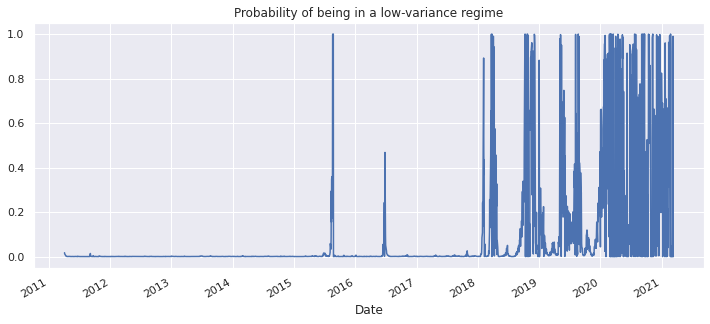

In [27]:
res_2.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in a low-variance regime', figsize=(12,5));

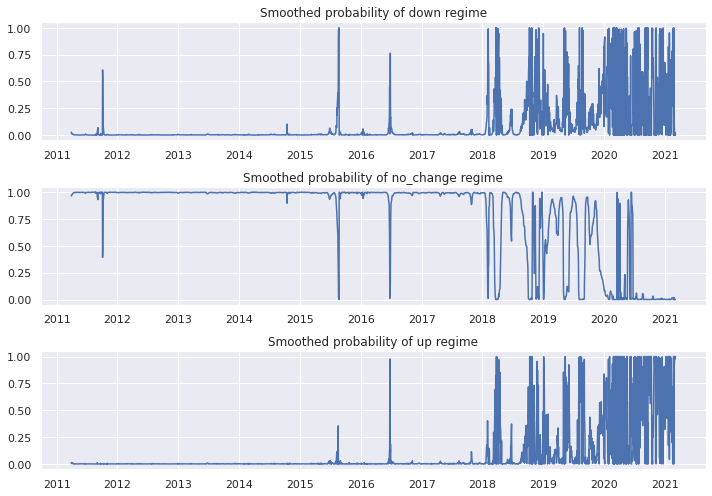

In [67]:
fig, axes = plt.subplots(3, figsize=(10,7))

ax = axes[0]
ax.plot(res_2.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of down regime')

ax = axes[1]
ax.plot(res_2.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime')

ax = axes[2]
ax.plot(res_2.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up regime')

plt.tight_layout()

In [28]:
print(res_2.expected_durations)

[  1.93261125 116.79402314   2.07639958]


In [ ]:
!pip install probscale
import probscale

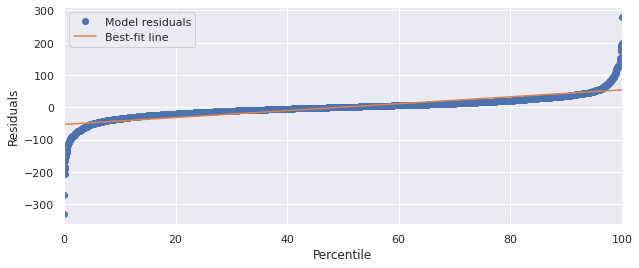

In [68]:
#qqpolot vs. normal distribution
fig, ax = plt.subplots(figsize=(10, 4))
plt.grid(True)
fig = probscale.probplot(res_2.resid, ax=ax, plottype='pp', bestfit=True,
                         problabel='Percentile', datalabel='Residuals',
                         scatter_kws=dict(label='Model residuals'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
plt.show()

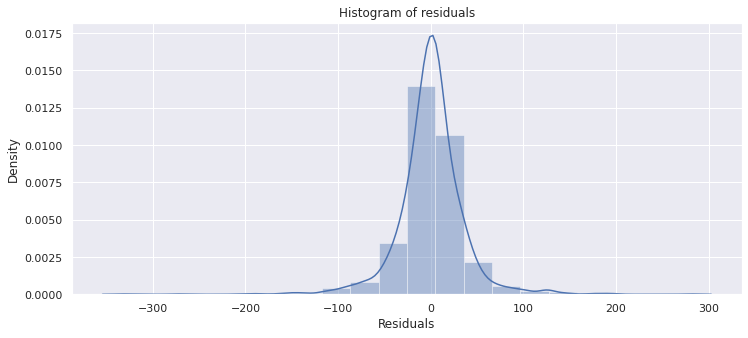

In [69]:
import seaborn as sns
plt.figure(figsize=(12,5))

# Plot a simple histogram with binsize determined automatically
sns.distplot(res_2.resid, 20)
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [70]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
results1 = sms.acorr_breusch_godfrey(res_2, 10)
print(lzip(name, results1))

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(res_2.resid)
print(lzip(name, results1))

[('Lagrange multiplier statistic', 66.25971354719512), ('p-value', 2.3255929417300673e-10), ('f-value', 3.067126686406801), ('f p-value', 0.0007005954827179799)]
[('Jarque-Bera', 66.25971354719512), ('Chi^2 two-tail prob.', 2.3255929417300673e-10), ('Skew', 3.067126686406801), ('Kurtosis', 0.0007005954827179799)]


In [71]:
print(res_2.expected_durations)

[ 1.91910735 89.20952665  2.27173369]


In [72]:
print(res_2.conf_int())

                     0             1
p[0->0]       0.293564      0.664285
p[1->0]      -0.001982      0.013418
p[2->0]       0.313487      0.513934
p[0->1]       0.010158      0.114292
p[1->1]       0.982334      0.995247
p[2->1]      -0.005213      0.058177
const[0]     10.582317     51.849601
const[1]     -6.755627      1.410181
const[2]     36.010746     70.641873
x1[0]       -36.902893     47.517064
x1[1]       -15.095900      2.110773
x1[2]       -13.660228     59.576497
x2[0]      4301.768316   7780.339264
x2[1]      4711.318230   5731.726638
x2[2]     21265.421265  22861.782442
x3[0]     -6854.049549  -3202.796774
x3[1]      -860.438463    342.944136
x3[2]    -11990.339546 -10109.046714
x4[0]     -4018.688052    331.998395
x4[1]       672.351042   1804.135341
x4[2]      4249.891683   6140.682461
sigma2     1358.477328   1539.033809


In [73]:
predict = res_2.predict()
predict = pd.DataFrame(predict.tail(20))
predict.rename(columns ={0: 'Predicted'}, inplace=True)
predict.rename(columns ={0: 'Predicted'}, inplace=True)
combine = pd.concat([predict, data['forecast_variable'].tail(20)], axis=1)
combine = combine.reset_index()
combine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,forecast_variable
0,2021-02-05,73.551935,78.559570
1,2021-02-08,112.397518,131.339844
2,2021-02-09,37.599253,20.060547
3,2021-02-10,-54.868943,-35.169922
4,2021-02-11,42.919338,53.239258
5,2021-02-12,54.197130,69.700195
6,2021-02-16,-53.435377,-47.969727
7,2021-02-17,16.759314,-82.009766
8,2021-02-18,6.300616,-100.129883
9,2021-02-19,-32.076693,9.099609


In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=combine['Date'],y=combine['forecast_variable'],
                         name="Actual Values (Adj Close"))

fig.add_trace(go.Scatter(x=combine['Date'],y=combine['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted values",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=500,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>